In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.0.0-dev20190823'

In [52]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
base_dir = 'Data/train'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip =True,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

# val_generator = datagen.flow_from_directory(
#     base_dir,
#     target_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE, 
#     subset='validation')

Found 997 images belonging to 5 classes.


In [53]:
batches = []
labels = []
count =0
for image_batch, label_batch in train_generator:
    batches.append(image_batch)
    labels.append(label_batch)
    if count==50:break
    count+=1
batches = np.concatenate(batches)
labels  = np.concatenate(labels)

In [54]:
batches.shape

(3183, 224, 224, 3)

<class 'numpy.ndarray'> [0. 0. 1. 0. 0.]


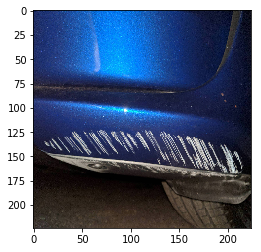

In [96]:
i=1344

print(type(batches[i]),labels[i])
plt.imshow(batches[i])

In [71]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [72]:
base_model.trainable = False

In [73]:
n_classes = 5

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [74]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [77]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [82]:
# epochs = 10

# history = model.fit(train_generator, 
#                     epochs=epochs)#, 
#                     #validation_data=val_generator)
history = model.fit(x=batches, y=labels, batch_size=64, epochs=3, verbose=1,
    callbacks=None, validation_split=0.15, validation_data=None,
    shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, 
    steps_per_epoch=None, validation_steps=None,
    validation_freq=1)

Train on 2705 samples, validate on 478 samples
Epoch 1/3
2705/2705 [==============================] - 64s 24ms/sample - loss: 0.1115 - accuracy: 0.9697 - val_loss: 0.7728 - val_accuracy: 0.7552
Epoch 2/3
2705/2705 [==============================] - 61s 22ms/sample - loss: 0.0727 - accuracy: 0.9830 - val_loss: 0.5816 - val_accuracy: 0.8096
Epoch 3/3
2705/2705 [==============================] - 61s 23ms/sample - loss: 0.0856 - accuracy: 0.9749 - val_loss: 0.5227 - val_accuracy: 0.8180


In [83]:
saved_model_dir = 'transfer_learning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('car_damage_classifier_5c.tflite', 'wb') as f:
    f.write(tflite_model)

Found 1 images belonging to 1 classes.


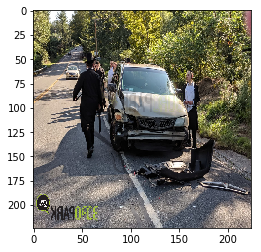

In [107]:
base_dir = "Data/Valid"
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1)

batches_v = []
labels_v = []
count =0
for image_batch, label_batch in val_generator:
    batches_v.append(image_batch)
    labels_v.append(label_batch)
    if count==1:break
    count+=1
batches_v = np.concatenate(batches_v)
labels_v  = np.concatenate(labels_v)
plt.imshow(batches_v[0])

In [108]:
pred = model.predict(np.array([batches_v[0]]), batch_size=None, verbose=0, steps=None, callbacks=None)
np.argmax(pred)

1

np.array([batches_v[0]].shape